## Used to create clusters of the vectorized data. 
* currently using good old k-means
* to visualize, we projected the data on 2d using PCA
* inspired by http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from sklearn.externals import joblib
from modeling_funcs import *


plt.rcParams['figure.figsize'] = (15.0, 15.0)


## Visualize results on PCA-reduced data

In [2]:

def visualize_kmeans(kmeans, data, resolution = 100):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
    y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()
    
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, s=10, edgecolor='none', cmap='Paired')
    # Plot the centroids as Xs
    centroids = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                c=range(len(centroids)), zorder=10, cmap='Paired')
    plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
              'Centroids are marked with crosses')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.figure(figsize=(40,40))
    plt.show()



In [3]:
proact_train = pd.read_csv('../train_data_vectorized.csv', sep = '|', index_col = 'SubjectID', dtype='float')
proact_train = proact_train[clustering_columns]
proact_train.head()

,ALSFRS_Total_last,ALSFRS_Total_mean_slope
SubjectID,,
533,-0.118551,-1.481164
649,1.079381,0.011470
1234,-1.487615,-0.263637
2492,0.052582,0.214504
2956,0.394848,-0.249574


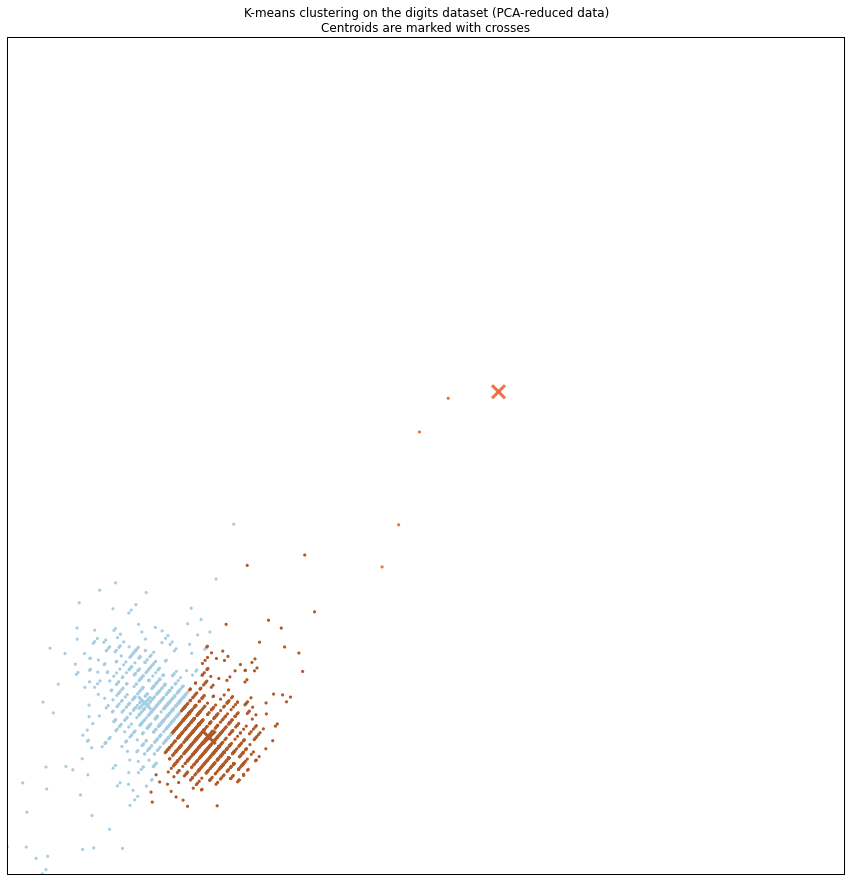

[(0.0098350545475724884, 'ALSFRS_Total_mean_slope'), (0.16220844755059666, 'ALSFRS_Total_last')]
Cluster cnt:  [ 642    5 1130]


In [4]:
kmeans = KMeans(init='k-means++', n_clusters=3)
kmeans.fit(proact_train)
visualize_kmeans(kmeans, proact_train)
print sorted([(metrics.adjusted_mutual_info_score(proact_train[col], kmeans.labels_), col) for col in proact_train.columns])
print "Cluster cnt: ", np.bincount(kmeans.labels_)

## Pickle the clustering model

In [5]:
clustering_model = {"columns": clustering_columns, "model": kmeans}
pickle.dump( clustering_model, open('../clustering_model.pickle', 'wb') )


In [6]:

for t in ['train', 'test']:
    cur_data = pd.read_csv('../' + t + '_data_vectorized.csv', sep = '|', error_bad_lines=False, index_col="SubjectID")
    cur_data = cur_data[clustering_columns]
    res = pd.DataFrame(index = cur_data.index.astype(str)) # SubjectID is always str for later joins
    res['cluster'] = kmeans.predict(cur_data)
    print t, res.shape
    res.to_csv('../' + t + '_kmeans_clusters.csv',sep='|')

train (1777, 1)
test (600, 1)


In [7]:
res.head()

,cluster
SubjectID,
750059,0
750094,2
750148,2
750195,2
750406,2
